# EmoArt: Real-Time Emotion Detection and Cartoon Style Transfer Using LoRA

### Group Details

- Srivatsan Rangarajan 101571286
- Mansi Kharb 101562748
- Sam Emami 101575471
- Tarunsai Chukkala 101543772
- Augustine Pullattu Chachochin 101540402
- Anusha Gundlapalli 101560347
- Bisman Singh 101543040 
- Rutul Patel 101539636

## 1. Project Summary

EmoArt is a real-time interactive system that detects facial emotions and transforms the user's smiling face into a stylized cartoon portrait. Built using YOLOv8 for face detection, the FER library for emotion classification, and a fine-tuned Stable Diffusion model using LoRA, the application is both playful and technically rich. It encourages users to smile by displaying humorous cat images, and once a sustained happy emotion is detected, generates a personalized cartoon image as a reward.

## 2. Dataset Summary

### 2.1 Cartoon Face Dataset (Training for Style Transfer)

- **Source:** Cartoon Set by Google https://google.github.io/cartoonset/
- **Size:** 10,000 PNG images (sampled 1,000)
- **Resolution:** 500x500
- **Purpose:** Fine-tuning Stable Diffusion via LoRA
- **Preprocessing:** Images resized to 512x512 for stable diffusion fine-tuning and 1000 images randomly sampled to reduce fine-tuning time.

### 2.2 Cat Meme Dataset (Interaction Stimulus)
- **Source:** Kaggle (Funny Cat Memes Dataset) https://www.kaggle.com/datasets/vekosek/cats-from-memes
- **Purpose:** Used as a stimulus to make the user smile 😀
- **Preprocessing:** Images resized and shuffled for display in the webcam feed

In [ ]:
"""This project will be perfomed locally on a laptop with NVIDIA GPU."""
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device:", torch.cuda.get_device_name(0))
    print("CUDA version:", torch.version.cuda)

CUDA available: True
Device: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA version: 11.8


## 3. Preprocessing 

### Cartoon Face Dataset

- The Cartoon Face Dataset is resized to 512x512 to meet the requirements for fine-tuning Stable Diffusion.

- Sampling: 1,000 images were sampled from the 10k dataset to reduce fine-tuning time.

- Prompt: "cartoon avatar of a face"

### Cat Meme Dataset

- Stored in local folder and randomly accessed

- Automatically resized during OpenCV display


In [ ]:
'''This script is used to create a curated subset of the CartoonSet 10k dataset.'''
import os
import random
import shutil

source_dir = "data\cartoonset10k\cartoonset10k"  # Path to your 10k images
target_dir = "data\curated_subset"

# Make sure target directory exists
os.makedirs(target_dir, exist_ok=True)

# List all PNG images (assuming they are .png)
image_files = [f for f in os.listdir(source_dir) if f.lower().endswith('.png')]

# Randomly sample 1000 images (or fewer if you don't have that many)
sample_size = min(1000, len(image_files))
sample_files = random.sample(image_files, sample_size)

# Copy the sampled files
for file_name in sample_files:
    shutil.copy(os.path.join(source_dir, file_name),
                os.path.join(target_dir, file_name))

print(f"Copied {len(sample_files)} images to {target_dir}")

Copied 1000 images to data\curated_subset


In [ ]:
'''This script is used to resize the images in the curated subset to 512x512.'''
import os
import cv2

input_dir = "data\curated_subset"
output_dir = "data/resized_subset"

os.makedirs(output_dir, exist_ok=True)

for img_name in os.listdir(input_dir):
    if img_name.lower().endswith(".png"):
        img_path = os.path.join(input_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        
        # Resize to 512x512
        resized_img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
        
        out_path = os.path.join(output_dir, img_name)
        cv2.imwrite(out_path, resized_img)


## 4. Model Architecture & Training

This project uses YOLOv11n for face detection. This is paired with FER for emotion classification. While the user is unhappy, funny memes are shown using the Cat Memes dataset. Once the user smiles for a set duration, the fine-tuned Stable Diffusion model creates a cartoonified version of the user.

- **YOLOv8n-Face**: Detects face bounding boxes in real-time webcam feed  https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8n-face.pt

- **FER (Facial Emotion Recognition)**: Classifies detected face into emotion categories: happy, sad, angry, etc.

- **Stable Diffusion v1.5 + LoRA**: https://github.com/huggingface/diffusers/tree/main/examples/dreambooth

- - Fine-tuned on 1,000 cartoon avatars

- - Style transfer using the Img2Img pipeline

- - Trained for 1,000 steps using train_dreambooth_lora.py

### 4.1 Fine-Tuning Stable Diffusion
The stable diffusion fine-tuning steps were primarily performed in the terminal. 

Here's a description of the steps performed:

1. The diffusers repo was cloned
``` 
git clone https://github.com/huggingface/diffusers
cd diffusers
pip install -e .
```

2. Requirements for this repo were installed:
```
pip install -r requirements.txt
```

3. Model was trained. See fine-tuning_training_log.txt for details:
```
accelerate launch train_dreambooth_lora.py ^
More?   --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" ^
More?   --instance_data_dir="C:\Users\sriva\OneDrive\Learning\Deep Learning\EmoArt-GenAI-Vision\data\resized_subset" ^
More?   --output_dir="C:\Users\sriva\OneDrive\Learning\Deep Learning\EmoArt-GenAI-Vision\data\lora_cartoon_model" ^
More?   --instance_prompt="cartoon avatar of a face" ^
More?   --resolution=512 ^
More?   --train_batch_size=1 ^
More?   --gradient_accumulation_steps=4 ^
More?   --checkpointing_steps=250 ^
More?   --learning_rate=1e-4 ^
More?   --lr_scheduler="constant" ^
More?   --lr_warmup_steps=0 ^
More?   --max_train_steps=1000 ^
More?   --seed=42 ^
More?   --mixed_precision="fp16"
```

(-0.5, 2559.5, 1599.5, -0.5)

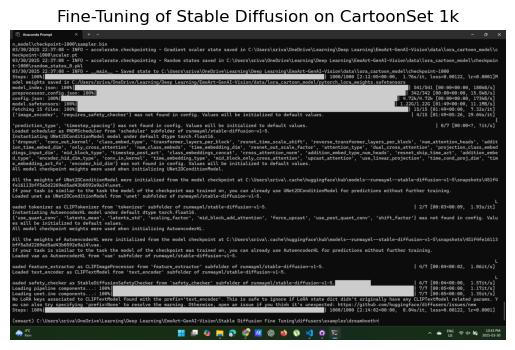

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
trained_screenshot = Image.open("fine-tuning Screenshot.png")
plt.imshow(trained_screenshot)
plt.title("Fine-Tuning of Stable Diffusion on CartoonSet 1k")
plt.axis("off")


### 4.2 Loading and Testing the fine-tuned model

Loading LoRA Fine-Tuned Model Locally

In [14]:
'''This script is used to load the LoRA weights and the base model.'''

from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch

# Load base model
base_model = "runwayml/stable-diffusion-v1-5"

# LoRA weights directory
lora_path = r"C:\Users\sriva\OneDrive\Learning\Deep Learning\EmoArt-GenAI-Vision\data\lora_cartoon_model"

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model,
    torch_dtype=torch.float16,
    scheduler=DPMSolverMultistepScheduler.from_pretrained(base_model, subfolder="scheduler")
)

# Load LoRA weights
pipe.load_lora_weights(lora_path)

# Move to GPU
pipe = pipe.to("cuda")

# Enable memory-efficient attention
#pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...: 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Testing the model with a sample prompt

In [ ]:
'''This script is used to generate images using the LoRA weights and the base model.'''
prompt = "a cartoon avatar of a very silly and funny face"
image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]

# Show image
image.show()

# Optionally save
image.save("data/test_lora_cartoon_output.png")


100%|██████████| 30/30 [00:03<00:00,  7.64it/s]


  plt.tight_layout()



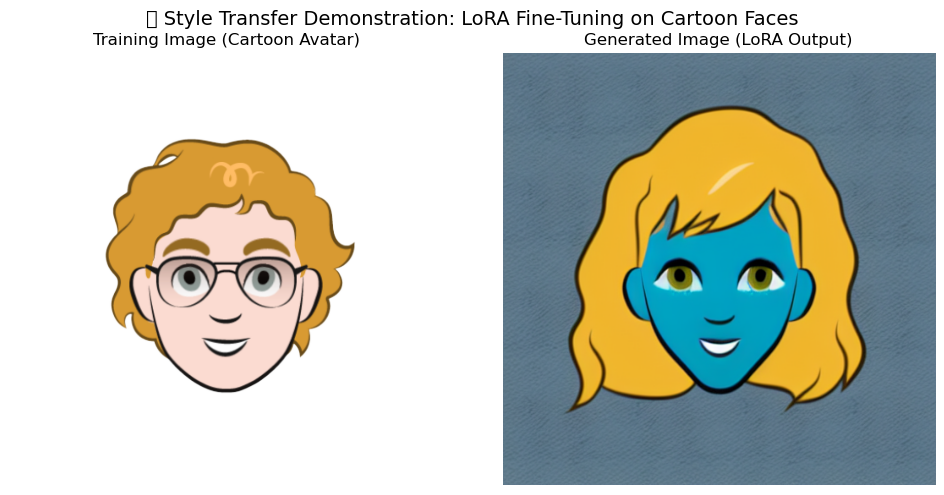

In [17]:
'''This script is used to visualize the training image and the generated image side by side.'''

import matplotlib.pyplot as plt
from PIL import Image
import os

# Load image from your training dataset
training_img_path = r"C:\Users\sriva\OneDrive\Learning\Deep Learning\EmoArt-GenAI-Vision\data\resized_subset\cs1048486361028912.png"
training_img = Image.open(training_img_path)

# Load image generated by your fine-tuned LoRA model
generated_img_path = r"C:\Users\sriva\OneDrive\Learning\Deep Learning\EmoArt-GenAI-Vision\data\test_lora_cartoon_output.png"
generated_img = Image.open(generated_img_path)

# Plot side-by-side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(training_img)
plt.title("Training Image (Cartoon Avatar)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(generated_img)
plt.title("Generated Image (LoRA Output)")
plt.axis("off")

plt.suptitle("🎯 Style Transfer Demonstration: LoRA Fine-Tuning on Cartoon Faces", fontsize=14)
plt.tight_layout()
plt.show()


## 5. Emotion to Cartoon Conversion Pipeline

1. Webcam feed initialized
2. YOLO detects face → FER classifies emotion
3. If not "happy": cat memes are shown beside face
4. If "happy" is sustained ≥ 3 seconds:
   - Freeze-frame is captured
   - Stable Diffusion (Img2Img) applies cartoon style
   - Output image saved and displayed

In [24]:
import os
import cv2
import torch
import random
import numpy as np
from PIL import Image
from fer import FER
from datetime import datetime, timedelta
from ultralytics import YOLO
from diffusers import StableDiffusionImg2ImgPipeline, DPMSolverMultistepScheduler

# === CONFIGURATION ===
LORA_PATH = "C:/Users/sriva/OneDrive/Learning/Deep Learning/EmoArt-GenAI-Vision/data/lora_cartoon_model"
FREEZE_PATH = "freeze_frame.png"
HAPPY_DURATION = 3  # seconds
IMG_RESOLUTION = 512
FUNNY_IMAGE_FOLDER = "data/cats/cats_from_memes"  # <- Change this to your actual path
FUNNY_IMAGE_DURATION = 2  # seconds

# === Load Stable Diffusion img2img pipeline ===
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.load_lora_weights(LORA_PATH)

# === Load YOLO Face Detector and FER ===
yolo = YOLO("yolov8n-face-lindevs.pt")
emotion_detector = FER(mtcnn=True)

# === Helper: Convert OpenCV frame to PIL ===
def frame_to_pil(frame):
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return Image.fromarray(rgb)

# === Load funny images from folder ===
funny_images = [cv2.imread(os.path.join(FUNNY_IMAGE_FOLDER, f)) for f in os.listdir(FUNNY_IMAGE_FOLDER) if f.endswith(('.png', '.jpg', '.jpeg'))]
funny_images = [img for img in funny_images if img is not None]
funny_images = [cv2.resize(img, (150, 150)) for img in funny_images]
random.shuffle(funny_images)
funny_idx = 0
last_funny_time = datetime.now()

# === Init ===
cap = cv2.VideoCapture(0)
happy_window = []  # Sliding window of emotion results
happy_threshold = 0.8  # 60% of last few frames must be happy
freeze_captured = False
print("😊 Smile and hold for 3s to get cartoonified!")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = yolo(frame)
    boxes = results[0].boxes if results else []
    current_emotion = "Unknown"
    user_smiling = False

    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        face = frame[y1:y2, x1:x2]

        if face.size > 0:
            emotion, score = emotion_detector.top_emotion(face)
            current_emotion = emotion if emotion else "Unknown"

            happy_window.append(emotion == "happy")
            if len(happy_window) > 30:
                happy_window.pop(0)

            happy_ratio = sum(happy_window) / len(happy_window)

            if happy_ratio >= happy_threshold and not freeze_captured:
                freeze_frame = frame.copy()  # Don't crop face, use entire frame
                cv2.imwrite(FREEZE_PATH, freeze_frame)
                freeze_captured = True
                print("🧊 Freeze frame captured! Generating cartoon...")

                init_image = frame_to_pil(freeze_frame).resize((IMG_RESOLUTION, IMG_RESOLUTION))
                cartoon = pipe(
                    prompt="cartoon avatar of a smiling person",
                    image=init_image,
                    strength=0.7,
                    guidance_scale=7.5
                ).images[0]

                cartoon_np = np.array(cartoon)[:, :, ::-1]
                freeze_frame_resized = cv2.resize(freeze_frame, (IMG_RESOLUTION, IMG_RESOLUTION))
                combined = np.hstack((freeze_frame_resized, cartoon_np))
                cv2.imwrite("Smiling-User.png", combined)
                cv2.imshow("🎨 Your Reward!", combined)

            label = f"{current_emotion} ({score:.2f})" if emotion and score else current_emotion
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    if current_emotion != "happy":
        cv2.putText(frame, "You are not smiling. That's not allowed.", (50, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        if (datetime.now() - last_funny_time).total_seconds() > FUNNY_IMAGE_DURATION:
            funny_idx = (funny_idx + 1) % len(funny_images)
            last_funny_time = datetime.now()

        funny_img = funny_images[funny_idx]
        if funny_img is not None:
            fh, fw = funny_img.shape[:2]
            if fh + 10 <= frame.shape[0] and fw + 10 <= frame.shape[1]:
                frame[10:10+fh, -10-fw:-10] = funny_img

    cv2.imshow("AI Dystopia: Only Happy Emotions Allowed", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Loading pipeline components...: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


😊 Smile and hold for 3s to get cartoonified!

0: 480x640 1 face, 12.4ms
Speed: 4.7ms preprocess, 12.4ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 9.2ms
Speed: 1.8ms preprocess, 9.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 14.7ms
Speed: 2.9ms preprocess, 14.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 16.3ms
Speed: 2.7ms preprocess, 16.3ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 15.6ms
Speed: 2.5ms preprocess, 15.6ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 20.5ms
Speed: 2.4ms preprocess, 20.5ms inference, 4.5ms postprocess per

100%|██████████| 35/35 [00:03<00:00,  8.97it/s]



0: 480x640 1 face, 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 9.8ms
Speed: 1.6ms preprocess, 9.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 9.5ms
Speed: 1.6ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 9.1ms
Speed: 1.3ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face, 15.3ms
Speed: 2.2ms preprocess, 15.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 face

## 6. Results

The model successfully generates cartoon portraits that reflect the training style

Visual comparison between input face and generated output confirms style transfer

The humorous image feedback loop is effective in triggering user smiles

(-0.5, 1023.5, 511.5, -0.5)

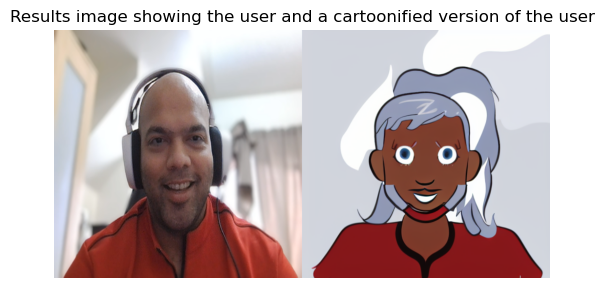

In [22]:
''' Displaying results'''
import matplotlib.pyplot as plt
from PIL import Image
results_img = Image.open("Smiling-User.png")
plt.imshow(results_img)
plt.title("Results image showing the user and a cartoonified version of the user")
plt.axis("off")

## 7. System Specifications

GPU: NVIDIA 4060 Laptop GPU (8GB VRAM)

RAM: 32 GB

Frameworks: PyTorch, Hugging Face Diffusers, OpenCV, Ultralytics YOLO, FER

Performance: Cartoon generation takes ~10s- 40s on local GPU

## 8. Challenges and Learnings


- Challenges 

- - Real-time FER is sensitive to slight facial changes

- - Img2Img style transfer required balanced prompt strength to preserve facial structure

- - Fine-tuning LoRA taught principles of lightweight model adaptation

- Learnings
- - LoRA is GPU-efficient and a strong fit for creative personalization

- - Integrating multiple ML models in real-time requires modular pipeline design

- - Emotion detection can be influenced by lighting, occlusion, and expression intensity

## 9. Future Scope

- To refine the UI and UX of the app by displaying the memes in a better fashion.
- To show loading screen when app is working in the background.
- To create a web app